# **The _k_-nearest neighbors (kNN) regression algorithm**

    Author: Jerónimo Arenas García (jarenas@tsc.uc3m.es)
            Jesús Cid Sueiro (jcid@tsc.uc3m.es)

    Notebook version: 2.3 (Sep 16, 2024)

    Changes: v.1.0 - First version
             v.1.1 - Stock dataset included.
             v.2.0 - Notebook for UTAD course. Advertising data incorporated
             v.2.1 - Text and code revisited. General introduction removed.
             v.2.2 - Compatibility with python 2 and 3.
             v.2.3 - (JCS) Removed compatibility with python 2. Improved code. 
                     From-scratch cross-validation replaced by sklearn code.

In [1]:
# Import some libraries that will be necessary for working with data and displaying plots

# To visualize plots in the notebook
%matplotlib inline 

# import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pylab

# Packages used to read datasets
import pandas as pd   # To read datasets in csv format

# Scikit-learn modules
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsRegressor

# That's default image size for this interactive session
# pylab.rcParams['figure.figsize'] = 9, 5  

## 1. The dataset

### 1.1. Data sources

We describe next the regression task that we will use in the session. The dataset is an adaptation of the <a href=http://www.dcc.fc.up.pt/~ltorgo/Regression/DataSets.html> `STOCK` dataset</a>, taken originally from the <a href=http://lib.stat.cmu.edu/> StatLib Repository</a>. The goal of this problem is to predict the values of the stocks of a given airplane company, given the values of another 9 companies in the same day. 

<small> If you are reading this text from the python notebook with its full functionality, you can explore the results of the regression experiments using two alternative datasets:

* The 
<a href=https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength>`CONCRETE` dataset</a>, taken from the <a href=https://archive.ics.uci.edu/ml/index.html>Machine Learning Repository at the University of California Irvine</a>. The goal of the `CONCRETE` dataset tas is to predict the compressive strength of cement mixtures based on eight observed variables related to the composition of the mixture and the age of the material). 

* The `Advertising` dataset, taken from the book <a href= http://www-bcf.usc.edu/~gareth/ISL/data.html> An Introduction to Statistical Learning with applications in R</a>, with permission from the authors: G. James, D. Witten, T. Hastie and R. Tibshirani. The goal of this problem is to predict the sales of a given product, knowing the investment in different advertising sectors. More specifically, the input and output variables can be described as follows:

  - *Input features:*
     * TV: advertising dollars spent on TV for a single product in a given market (in thousands of dollars)
     * Radio: advertising dollars spent on Radio
     * Newspaper: advertising dollars spent on Newspaper
     
  - *Response variable:*
     * Sales: sales of a single product in a given market (in thousands of widgets)

To do so, just replace `stock` by `concrete` or `advertising` in the next cell. Remind that you must run the cells again to see the changes. 
</small>

In [2]:
# SELECT dataset
# Available options are 'stock', 'concrete' or 'advertising'
ds_name = 'stock'
# ds_name = 'concrete'
# ds_name = 'advertising'

### 1.2. Loading data into a dataframe.

First, we load the data from the source files, in `csv` or `xls` format. To do so, we use methods from the `pandas` library. 

In [3]:
# Load the selected dataset from the input file into a dataframe
if ds_name == 'stock':
    df = pd.read_csv('datasets/Stock.csv', header=None)
    
elif ds_name == 'concrete':
    df = pd.read_excel('datasets/Concrete_Data.xls')

elif ds_name == 'advertising':    
    df = pd.read_csv('datasets/Advertising.csv')

else:
    print('Unknown dataset')


The dataset has been loaded into a table-like structure, `df`, named **dataframe**. To inspect the values in the dataframe, we can use the <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.head.html">`head()`</a> method.

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9
0,17.219,50.500,18.750,43.000,60.875,26.375,67.750,19.000,48.750,34.875
1,17.891,51.375,19.625,44.000,62.000,26.125,68.125,19.125,48.750,35.625
2,18.438,50.875,19.875,43.875,61.875,27.250,68.500,18.250,49.000,36.375
3,18.672,51.500,20.000,44.000,62.625,27.875,69.375,18.375,49.625,36.250
4,17.438,49.000,20.000,41.375,59.750,25.875,63.250,16.500,47.500,35.500


an see some overall data statistics through the <a href="https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.describe.html">`describe()`</a> method

In [5]:
# Display some stats from the dataframe
df.describe()

,0,1,2,3,4,5,6,7,8,9
count,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000,950.000000
mean,37.925592,43.955526,18.704474,45.352895,60.863553,24.122632,70.673421,23.294211,44.214211,46.994079
std,10.759764,11.377308,2.730364,5.606898,14.299412,5.530962,6.773101,2.970152,4.270098,6.539420
min,17.219000,19.250000,12.750000,34.375000,27.750000,14.125000,58.000000,16.375000,31.500000,34.000000
25%,27.781000,35.406250,16.125000,41.375000,49.656250,18.000000,65.625000,21.250000,41.750000,41.375000
50%,38.922000,49.062500,19.375000,43.937500,61.750000,25.750000,68.625000,22.500000,44.750000,46.687500
75%,46.875000,53.250000,20.875000,48.125000,71.843750,28.875000,76.375000,26.375000,47.625000,52.125000
max,61.500000,60.250000,25.125000,60.125000,94.125000,35.250000,87.250000,29.250000,53.000000,62.000000


### 1.3. Feature matrix and target variables

In all these datasets, the last column of the dataframe contains the target variable.  All the other columns contain the input features. 

We will load all input features and the target variable into the input data matrix **`X`** and the column vector **`S`**, respectively.


In [6]:
# Load last column into target variable S as a column vector
S = df.iloc[:, -1].values[:, np.newaxis]

# The other columns are the input variables (features)
X = df.iloc[:, :-1].values

# Display the shape of the input and target variables
n_samples, n_features = X.shape 
print(f'-- Number of samples: {n_samples}')  
print(f'-- Number of features: {n_features}')

# This is to make sure that shuffling is done only once (see later)
is_shuffled = False

-- Number of samples: 950
-- Number of features: 9


### 1.4. Dataset split: train, validation and test

Our goal is to predict the value of the target variable given the value of the features. Remind that a effective regression algorithm should be able to make good predictions for input data not used during learning. To do so, we need at least two dataset, 

* **Training** set: used to fit a predictor of the target variable
* **Test** set: used to evaluate the performance of the selected predictor.

For reasons that will be clear later, a third dataset may be required:

* **Validation** set: used to select the best predictor of unseen samples, among a finite set of candidates.

To make sure that the data distribution of the three elements in the partition is the same, samples should be previously shuffled

In [7]:
if not is_shuffled:
    # For reproducibility, to make the same shuffle every time
    np.random.seed(42)   

    # Generate a random permutation of the indices of the samples
    shuffle = np.random.permutation(n_samples)   

    # Shuffle the samples   
    X = X[shuffle]
    S = S[shuffle]

# This is to make sure thatshuffling is not repeated running this cell again
is_shuffled = True

Now, we are ready to make the data split.

In [8]:
# Split the dataset into three sets: training (50%), validation (25%) and test (25%)
n_trn = int(n_samples * 0.5)
n_val = int(n_samples * 0.25)
n_tst = n_samples - n_trn - n_val

X_trn = X[: n_trn]
S_trn = S[: n_trn]
X_val = X[n_trn : n_trn + n_val]
S_val = S[n_trn : n_trn + n_val]
X_tst = X[n_trn + n_val:]
S_tst = S[n_trn + n_val:]

In [9]:
# Print the data dimension and the dataset sizes
print("SELECTED DATASET: " + ds_name)
print(f"---- The feature matrix of the training set contains {n_trn} samples with dimension {n_features}.")
print(f"---- The target variable of the training set contains {n_trn} values")
print(f"---- The feature matrix of the validation set contains {n_val} samples with dimension {n_features}.")
print(f"---- The target variable of the validation set contains {n_val} values")
print(f"---- The feature matrix of the testing set contains {n_tst} samples with dimension {n_features}.")
print(f"---- The target variable of the testing set contains {n_tst} values")


SELECTED DATASET: stock
---- The feature matrix of the training set contains 475 samples with dimension 9.
---- The target variable of the training set contains 475 values
---- The feature matrix of the validation set contains 237 samples with dimension 9.
---- The target variable of the validation set contains 237 values
---- The feature matrix of the testing set contains 238 samples with dimension 9.
---- The target variable of the testing set contains 238 values


### 1.5. Data visualization: scatter plots

We can get a first rough idea about the regression task representing the *scatter plot* of each of the one-dimensional variables against the target data. 

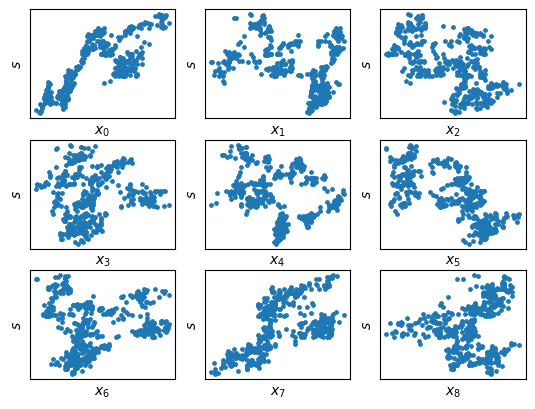

In [10]:
pylab.subplots_adjust(hspace=0.2)
for idx in range(n_features):
    ax1 = plt.subplot(3, 3, idx + 1)
    ax1.scatter(X_trn[:,idx], S_trn, s=6)
    ax1.get_xaxis().set_ticks([])
    ax1.get_yaxis().set_ticks([])
    plt.xlabel(f'$x_{idx}$')    
    plt.ylabel('$s$')
plt.show()

### x_0 looks nice. But we would use all of them in practise 

What would be the first guess? Just average the values of S -> Baseline estimation in regression.

## 2. Baseline estimation. Using the average of the training set labels

A first very simple method to build the regression model is to use the average of all the target values in the training set as the output of the model, ignoring the value of the input feature vector, ${\bf x}$.

This approach can be considered as a baseline: any regression algorithm making an effective use of the observation variables statistically related to $s$, should get a smaller error than the baseling.

The baseline prediction is thus given by

In [11]:
# Mean of all target values in the training set
s_hat = np.mean(S_trn)
print(s_hat)

46.869473684210526


for any input ${\bf x}$.

##### Exercise 1

Compute the mean square error over training, validation and test sets, for the baseline estimation  method.

In [12]:
# We start by defining a function that calculates the average square error
def square_error(s, s_est):    
    y = np.mean((np.squeeze(s) - np.squeeze(s_est))**2)

    # Note: squeeze is used to avoid unexpected results when s and s_est are
    #       are a row and a column vector, respectivelly, or viceversa.
    #       In such case, y = np.mean((s - s_est)**2) would not rise and
    #       error in python, which applies broadcasting.
    return y

# Mean square error of the baseline prediction over the training data
# MSE_trn = <FILL IN>
MSE_trn = square_error(S_trn, s_hat)

# Baseline MSE over the validation data
# MSE_val = <FILL IN>
MSE_val = square_error(S_val, s_hat)

# Baseline MSE over the test data
# MSE_tst = <FILL IN>
MSE_tst = square_error(S_tst, s_hat)

print(f'Baseline MSE in the training set: {MSE_trn:.4f}')
print(f'Baseline MSE in the  set: {MSE_val:.4f}')
print(f'Baseline MSE in the test set: {MSE_tst:.4f}')    

Baseline MSE in the training set: 43.2371
Baseline MSE in the  set: 41.2798
Baseline MSE in the test set: 43.1801


##### MSE is similar in all sets. This is reasonable.

Note that in the previous piece of code, function 'square_error' can be used when the second argument is a number instead of a vector with the same length as the first argument. The value will be subtracted from each of the components of the vector provided as the first argument (*broadcasting*).

In [13]:
np.testing.assert_allclose(MSE_trn, square_error(S_trn, s_hat), err_msg='Incorrect value for MSE_trn')
print("No assessment errors. First test passed")
np.testing.assert_allclose(MSE_val, square_error(S_val, s_hat), err_msg='Incorrect value for MSE_valk')
print("No assessment errors. Second test passed")
np.testing.assert_allclose(MSE_tst, square_error(S_tst, s_hat), err_msg='Incorrect value for MSE_tst')
print("No assessment errors. Third test passed")

No assessment errors. First test passed
No assessment errors. Second test passed
No assessment errors. Third test passed


## 3. Unidimensional regression with the $k$-nn method

The principles of the $k$-nn (or, simethod are the following:

   - For each point where a prediction is to be made, find the $k$ closest neighbors to that point (in the training set)
   - Obtain the estimation averaging the labels corresponding to the selected neighbors
   
The number of neighbors is an **hyperparameter** that plays an important role in the performance of the method. You can test its influence by changing $k$ in the following piece of code. In particular, you can sart with $k=1$ and observe the efect of increasing the value of $k$.

A simple implementation of the $k$-nn regresion algorith is shown below.

In [14]:
#
# A simple implementation of the knn regression algorithm
#
from scipy import spatial    # Used to compute the distance matrix

# This is very inefficient. He will tell us later why
def knn_regression(X1, S1, X2, k):
    """ Compute the k-NN regression estimate for the observations contained in
        the rows of X2, for the training set given by the rows in X1 and the
        components of S1. k is the number of neighbours of the k-NN algorithm
    """

    # This is used to make sure that X1 and X2 are matrices (inputs by rows)
    if (X1.ndim == 1) or (X2.ndim == 1):
        print("Error: input data are not 2D")
        return 0

    # Compute the matrix of Euclidean distances between the points in X1 and X2
    distances = spatial.distance.cdist(X1, X2,'euclidean')

    # Sort neighbors by increasing distance
    neighbors = np.argsort(distances, axis=0, kind='quicksort', order=None)

    # Find the k-nearest neighbors of each point in X2
    closest = neighbors[:k, :]
    
    # Compute prediction as the average target value of the k-nearest neighbors
    est_values = np.zeros([X2.shape[0], 1])
    for idx in range(X2.shape[0]):
        est_values[idx] = np.mean(S1[closest[:, idx]])

    return est_values

We can apply knn to predict the target variable $s$ from the first variable (feature $x_0$) from the dataset:

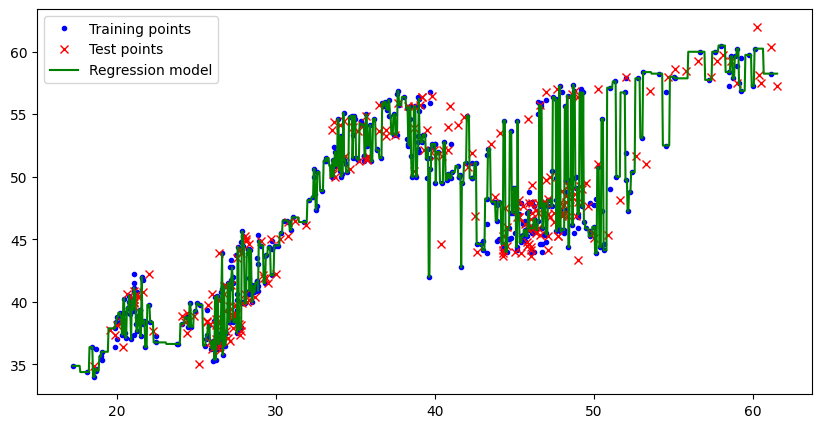

In [15]:
# Parameters for the regression model.
# You may change var and k to see the effect of different values
i = 0 # pick a variable (e.g., any value from 0 to 8 for the STOCK dataset)
k = 1 # Number of neighbors
n_points = 1000 # Points in the 'x' axis (for representational purposes)
# Select the variable to be used in the regression model
Xi_trn = X_trn[:,[i]] # We use [i] to make sure that Xi_tr is a column␣vector
Xi_val = X_val[:,[i]]
Xi_tst = X_tst[:,[i]]
# For representational purposes, we will compute the output of the regression␣model
# in a series of equally spaced-points along the x-axis
x_min = np.min([np.min(Xi_trn), np.min(Xi_val)])
x_max = np.max([np.max(Xi_trn), np.max(Xi_val)])
# Generate the grid as a column vector
X_grid = np.linspace(x_min, x_max, num=n_points)[:, np.newaxis]
# Apply the k-NN regression model to the validation set
est_tst = knn_regression(Xi_trn, S_trn, Xi_val, k)
# Apply the k-NN regression model to the grid (for representational purposes)
est_grid = knn_regression(Xi_trn, S_trn, X_grid, k)
# Plot the regression model
plt.figure(figsize=(10, 5))
plt.plot(Xi_trn, S_trn, 'b.', label='Training points')
plt.plot(Xi_val, S_val, 'rx', label='Test points')
plt.plot(X_grid, est_grid, 'g-', label='Regression model')
plt.axis('tight')
plt.legend(loc='best')
plt.show()

##### We can only plot this as we are only using 1 variable. This is not good we are overestimating the data. We can increase k, so more neighbours

### 3.1. Evolution of the error with the number of neighbors ($k$)

We see that a small $k$ results in a regression curve that exhibits many and large oscillations.  The curve is capturing any noise that may be present in the training data, and **overfits** the training set. On the other hand, picking a too large $k$ (e.g., 200) the regression curve becomes too smooth, averaging out the values of the labels in the training set over large intervals of the observation variable.

Since, for each value of $k$ we have a different predictor, we would like to select the one that makes the best predictions with new data. This is why we need a **validation** set.

The next code illustrates this effect by plotting the average training and validation MSE as a function of $k$. 

In [16]:
k_max = 60
# This is to make sure that k_max is not larger than the number of samples
k_max = np.minimum(k_max, n_trn)
# Apply the regression model to training and test data
# Be careful with the use of range: range(3) = [0,1,2] and range(1,3) = [1,2]
MSEk_trn = [square_error(S_trn, knn_regression(Xi_trn, S_trn, Xi_trn, k))
for k in range(1, k_max+1)]
MSEk_val = [square_error(S_val, knn_regression(Xi_trn, S_trn, Xi_val, k))
for k in range(1, k_max+1)]
# Select best model according to the validation MSE
k_opt = np.argmin(MSEk_val) + 1

Once we have selected the best model, we could use the validation MSE as a measure of its performance. However, it can be shown that this is a biased estimate. This why we still need a **test** set to evaluate the final model.


In [17]:
MSE_tst = square_error(S_tst, knn_regression(Xi_trn, S_trn, Xi_tst, k_opt))

The figure show the training, validation and test MSE, as a function of $k$.

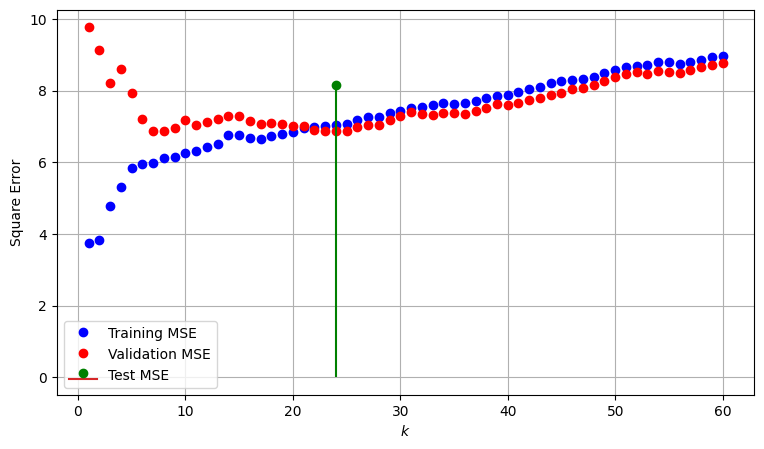

In [18]:
kgrid = np.arange(1, k_max+1)
plt.figure(figsize=(9, 5))
plt.plot(kgrid, MSEk_trn,'bo', label='Training MSE')
plt.plot(kgrid, MSEk_val,'ro', label='Validation MSE')
plt.stem(k_opt, MSE_tst, 'go', label='Test MSE')
plt.xlabel('$k$')
plt.ylabel('Square Error')
plt.grid()
plt.axis('tight')
plt.legend(loc='best')
plt.show()

As we can see, the error initially decreases achiving a minimum (in the test set) for some finite value of $k$, in this case

Increasing the value of $k$ beyond that value results in poorer performance.

Note that there may be some **variability** in the results. You can try to re-run this notebook changing the seed used to shuffle the original dataset: this would change the train, validation and test sets, and the optimal value of $k$ may change, as well as the test MSE. This variability is a consequence of the finite sample size.

In general, the larger the sample size, the smaller variability. In any case, for finite sample size, the best value of $k$ according to the validation set may be not theoretically optimal, but good enough to make reasonable good predictions without overfitting.

#### Exercise 2

Analize the training MSE for $k=1$. Why is it smaller than for any other $k$? Under which conditions will it be exactly zero?

#### Exercise 3

Modify the code above to visualize the square error from $k=1$ up to $k$ equal to the number of training instances. Can you relate the square error of the $k$-NN method with that of the baseline method for certain value of $k$? 

### 3.2. Influence of the input variable


Having a look at the scatter plots, we can observe that some observation variables seem to have a more clear relationship with the target value. Thus, we can expect that not all variables are equally useful for the regression task. In the following plot, we carry out a study of the performance that can be achieved with each variable. 

Note that, in practice, the test labels are not available for the selection of hyperparameter
$k$, so we should be careful about the conclusions of this experiment. A more realistic approach will be studied later when we introduce the concept of model validation.

In [19]:
k_max = 20

# MSE and k_opt for each feature will be stored in these lists
MSE_val = []
k_opt = []

# Evaluate each variable
for i in range(n_features):
    # Select feature i only
    Xi_trn = X_trn[:,[i]]     # We use [i] to make Xi_tr a column vector
    Xi_val = X_val[:,[i]]

    # Evaluate kNN for feature i
    MSE_val_vs_k = [square_error(S_val, knn_regression(Xi_trn, S_trn, Xi_val, k)) 
                    for k in range(1, k_max+1)]

    # Choose k that minimizes the validation error
    k_opt_i = np.argmin(MSE_val_vs_k) + 1

    # Save the result in the list
    k_opt.append(k_opt_i)
    MSE_val.append(MSE_val_vs_k[k_opt_i - 1])

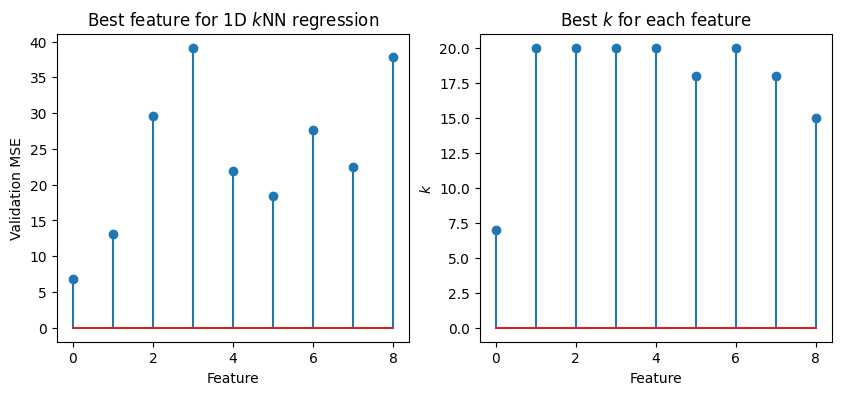

-- Selected feature: 0


In [20]:
# Plot the MSE of the validation set for each feature
plt.figure(figsize=(10, 4))
plt.subplot(121)
plt.stem(range(n_features), MSE_val)
plt.title('Best feature for 1D $k$NN regression')
plt.xlabel('Feature')
plt.ylabel('Validation MSE')

# Plot the selected value of k for each feature
plt.subplot(122)
plt.stem(range(n_features), k_opt)
plt.xlabel('Feature')
plt.ylabel('$k$')
plt.title('Best $k$ for each feature')
plt.show()

print(f'-- Selected feature: {np.argmin(MSE_val)}')

## 4. Multidimensional $k$-NN regression

In the previous subsection, we have studied the performance of the $k$-nn method when using only one feature. Doing so was convenient, because it allowed us to plot the regression curves in a 2-D plot, and to get some insight about the consequences of modifying the number of neighbors.

For completeness, we evaluate now the performance of the $k$-nn method in this dataset when using all variables together. In fact, when designing a regression model, we should proceed in this manner, using all available information to make as accurate an estimation as possible. In this way, we can also account for correlations that might be present among the different observation variables, and that may carry very relevant information for the regression task.

For instance, in the `STOCK` dataset, it may be that the combination of the stock values of two airplane companies is more informative about the price of the target company, while the value for a single company is not enough.

<small> Also, in the `CONCRETE` dataset, it may be that for the particular problem at hand the combination of a large proportion of water and a small proportion of coarse grain is a clear indication of certain compressive strength of the material, while the proportion of water or coarse grain alone are not enough to get to that result.</small>


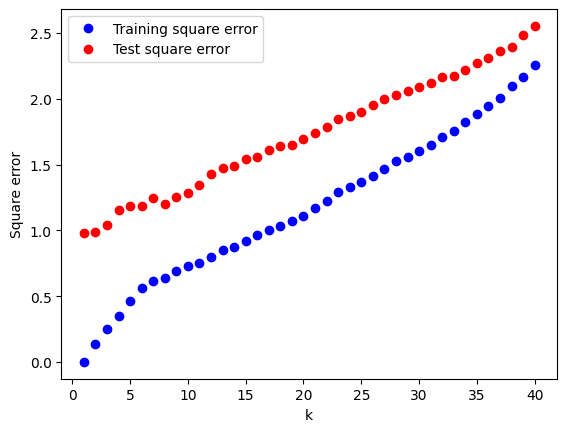

In [21]:
k_max = 40

MSE_trn = [square_error(S_trn, knn_regression(X_trn, S_trn, X_trn, k)) for k in range(1, k_max+1)]
MSE_tst = [square_error(S_tst, knn_regression(X_trn, S_trn, X_tst, k)) for k in range(1, k_max+1)]

plt.plot(np.arange(k_max)+1, MSE_trn, 'bo', label='Training square error')
plt.plot(np.arange(k_max)+1, MSE_tst, 'ro', label='Test square error')

plt.xlabel('k')
plt.ylabel('Square error')
plt.legend(loc='best')
plt.show()

In this case, we can check that the average test square error is much lower than the error that was achieved when using only one variable, and also far better than the baseline method. It is also interesting to note that in this particular case the best performance is achieved for a small value of $k$, with the error increasing for larger values of the hyperparameter.

Nevertheless, as we discussed previously, these results should be taken carefully. How would we select the value of $k$, if test labels are (obvioulsy) not available for model validation?

## 5. Hyperparameter selection via cross-validation

### 5.1. Cross validation

The need to use a validation set has reduced the amount of data (in the training set) that we can use to fit the regression model. Reducing the size of the validation set is not a good idea, because it increases the variance of the MSE estimates, inducing errors in the selection of the hyperparameter. Also, reducing the size of the test set increases the variance of the MSE estimate of the final model.

The **cross-validation** procedure is a clever solution to this proble by following these steps:

   - **Split** the training data into several (generally non-overlapping) subsets. If we use $M$ subsets, the method is referred to as $M$-fold cross-validation. If we consider each pattern a different subset, the method is usually referred to as leave-one-out (LOO) cross-validation.
   - Carry out the **training** of the system $M$ times. For each run, use a different partition as a <i>validation</i> set, and use the restating partitions as the training set. Evaluate the performance for different choices of the hyperparameter (i.e., for different values of $k$ for the $k$-NN method).
   - **Average** the validation error over all partitions, and pick the hyperparameter that provided the minimum validation error.
   - **Rerun** the algorithm using all the training data, keeping the value of the parameter that came out of the cross-validation process.
   
<center> <img src="https://chrisjmccormick.files.wordpress.com/2013/07/10_fold_cv.png"> </cente>


The python <a href="https://scikit-learn.org/stable/">scikit-learn</a> package provides a powefull collection of classes and methods to facilitate he application of this and many other variants of <a href="https://scikit-learn.org/stable/modules/cross_validation.html">cross validation</a>. The above scheme can be easily implemented using the `Kfold` class.

To do so, we will first merge our train and validation set into a single set for cross validation:

In [22]:
# We can merge our training and validation sets into a single cv set.
X_cv = np.vstack((X_trn, X_val))
S_cv = np.vstack((S_trn, S_val))

 Now, we can use the `split` method from the `Kfold` class to get the indices of the training and validation sets for each fold. We will use 5 folds.

In [23]:
# Parameters:
k_max = 40  # Maximum value of the k-nn hyperparameter to explore
n_splits = 5  # Number of folds in the cross-validation

# Now we create the KFold object with 5 folds
kf = KFold(n_splits=n_splits)

# Obtain the validation errors for each fold
MSE_val = np.zeros((k_max))
for i, (trn_index, val_index) in enumerate(kf.split(X_cv, S_cv)):
    print(f"Fold {i}:  \r", end="", flush=True)

    # Compute the MSE, for this fold, for each k
    MSE_val_i = [square_error(S_cv[val_index], 
                              knn_regression(X_cv[trn_index, :], S_cv[trn_index], 
                                             X_cv[val_index, :], k)) 
                 for k in range(1, k_max+1)]

    # Sum the MSE for each fold    
    MSE_val = MSE_val + np.array(MSE_val_i)

MSE_val = MSE_val / n_splits

# Select the best k based on the validation error
k_best = np.argmin(MSE_val) + 1
print(f'-- Best value of k: {k_best}')


-- Best value of k: 2


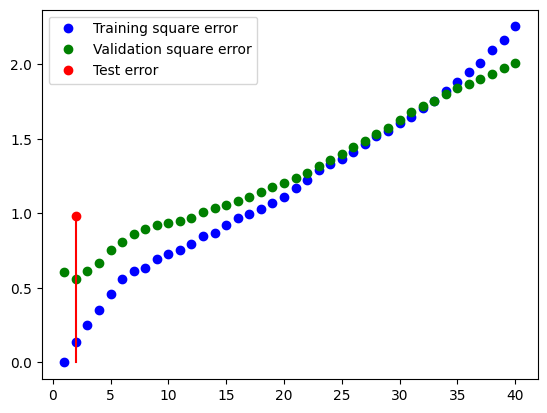

In [24]:
# Compute the final test MSE for the selecte k
MSE_tst = square_error(S_tst, knn_regression(X_trn, S_trn, X_tst, k_best))

plt.plot(np.arange(k_max)+1, MSE_trn, 'bo', label='Training square error')
plt.plot(np.arange(k_max)+1, MSE_val, 'go', label='Validation square error')
plt.plot([k_best, k_best], [0, MSE_tst],'r-')
plt.plot(k_best, MSE_tst,'ro',label='Test error')
plt.legend(loc='best')
plt.show()

##### Exercise 4

Modify the previous code to use only one of the variables in the input dataset
  - Following a cross-validation approach, select the best value of $k$ for the $k$-nn based in variable 0 only.
  - Compute the test error for the selected valua of $k$.

## 6. Scikit-learn implementation of $k$-NN

In practice, most well-known machine learning methods are implemented and available for python. Probably, the most complete module for machine learning tools is <a href=http://scikit-learn.org/stable/>Scikit-learn</a> (abbreviated, sklearn). 

The package contains a specific class for $k$-nn regression named <a href="https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html#sklearn.neighbors.KNeighborsRegressor">`KNeighborsRegressor`</a>. As for any other prediction methods, the basic use of an <a href=http://scikit-learn.org/stable/>sklearn</a> consists of three basic steps:

  1. **Create** the regresion object: `my_knn = KNeighborsRegressor(n_neighbors=5)` (you can check the)
  2. **Fit** the regression model using the training data, using the `fit` method: `my_knn.fit(X_trn, S_trn)`
  3. **Make predictions** for new data, using the `predict` method: `S_est = my_knn.predict(X_val)`

Below we apply a 1-NN over feature 0 to illustrate this process.

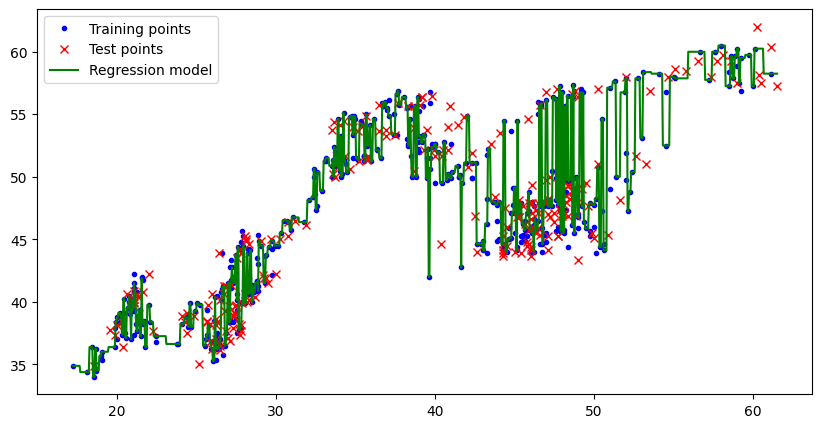

In [25]:
# Parameters for the regression model.
# You may change var and k to see the effect of different values 
i = 0  # pick a variable (e.g., any value from 0 to 8 for the STOCK dataset)
k = 1    # Number of neighbors

n_points = 1000  # Points in the 'x' axis (for representational purposes)

# Select the variable to be used in the regression model
Xi_trn = X_trn[:,[i]]     # We use [i] to make sure that Xi_tr is a column vector
Xi_val = X_val[:,[i]]
Xi_tst = X_tst[:,[i]]

# For representational purposes, we will compute the output of the regression model
# in a series of equally spaced-points along the x-axis
x_min = np.min([np.min(Xi_trn), np.min(Xi_val)])
x_max = np.max([np.max(Xi_trn), np.max(Xi_val)])
# Generate the grid as a column vector
X_grid = np.linspace(x_min, x_max, num=n_points)[:, np.newaxis]

# #############################################################################
# Using sklearn:

# Create the k-NN object from sklearn
my_knn = KNeighborsRegressor(n_neighbors=k)
# Fit the model to the training data
my_knn.fit(Xi_trn, S_trn)

# Predict the target values for the validation set
est_val = my_knn.predict(Xi_val)
# Predict the target values for the grid
est_grid = my_knn.predict(X_grid)
# #############################################################################

# Plot the regression model
plt.figure(figsize=(10, 5))
plt.plot(Xi_trn, S_trn, 'b.', label='Training points')
plt.plot(Xi_val, S_val, 'rx', label='Test points')
plt.plot(X_grid, est_grid, 'g-', label='Regression model')
plt.axis('tight')
plt.legend(loc='best')
plt.show()



The `KNeighborsRegressor` class from `scikit-learn` has a parameter called `weights` that can be used to assign different weights to the neighbors. The default value is `uniform`, which means that all neighbors have the same weight, and it is the model we have used so far. The other option is `distance`, which assigns weights to the neighbors based on the inverse of their distance.


##### Exercise 5

Select the best model via cross validation with 10 folds using the `distance` option.
